In [2]:
from collections.abc import Sized, Iterable

class NpDict(Sized, Iterable):
    
    def __init__(self, size, start, default=0., low=None, high=None, dtype=np.float):
        self.a = np.full(size, default, dtype=dtype)
        self.start = start
        self.default = 0
        self.low = low
        self.high = high
    
    @classmethod
    def add_to_slice(cls, s, x):
        if isinstance(s, slice):
            start = s.start
            stop = s.stop
            step = s.step
            if start is not None:
                start += x
            if stop is not None:
                stop += x
            return slice(start, stop, step)
        elif isinstance(s, Iterable):
            return tuple(cls.add_to_slice(_s, x) for _s in s)
        else:
            return s + x
    
    
    def clip_slice(self, s):
        if s.stop is not None:
            s.stop = min(len(self.a), s.stop)
        elif s.start is not None:
            s.start = max(0, s.start)
        return s
    
    def defaults(self):
        l = self.a[0]
        if self.low is not None:
            l = self.a.dtype.type(self.low)
        h = self.a[-1]
        if self.high is not None:
            h = self.a.dtype.type(self.high)
        return l, h
        
    def __setitem__(self, k, v):
        index = self.add_to_slice(k, -self.start)
        self.a[index] = v  
    
    def __getitem__(self, k):
        i = self.add_to_slice(k, -self.start)
        
        if isinstance(i, slice):
            padding = [0, 0]
            if i.start < 0:
                padding[0] = -i.start
            if i.stop >= len(self.a):
                padding[1] = i.stop - len(self.a) 
            self.clip_slice(i)
            return np.pad(self.a[i], padding, 'constant', constant_values=self.defaults())
        elif isinstance(i, Iterable):
            return np.array([self[_i] for _i in i])
        else:
            defaults = self.defaults()
            if i < 0:
                return defaults[0]
            elif i >= len(self.a):
                return defaults[1]
            else:
                return self.a[i]
    
    def __contains__(self, k):
        return k in self.a
    
    def __iter__(self):
        return self.a
        
    def __len__(self):
        return len(self.a)
    
    @classmethod
    def from_tuples(cls, list_of_tuples, **kwargs):
        s = sorted(list_of_tuples)
        size = s[-1][1] - s[0][0]
        start = s[0][0]
        a = cls(size, start, **kwargs)
        for l, h, v in s:
            a[l:h] = v
        return a
    
    def __str__(self):
        return "{}({})(\n{})".format( self.__class__.__name__, self.start, self.a)
        
    def __repr__(self):
        return str(self)

NameError: name 'np' is not defined

## Cost of an assembly junction

For gibson assembly. For golden gate assembly, additional sequence will have to added to the primer, reducing the extensibility.

float64
(199, 199, 998)
[[-300 -301 -302 ... -481 -482 -483]
 [-299 -300 -301 ... -480 -481 -482]
 [-298 -299 -300 ... -479 -480 -481]
 ...
 [ 695  694  693 ...  514  513  512]
 [ 696  695  694 ...  515  514  513]
 [ 697  696  695 ...  516  515  514]]
(998, 199, 199)


/Users/justinvrana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide


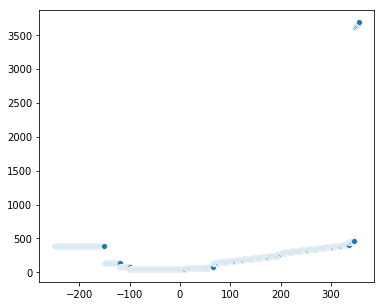

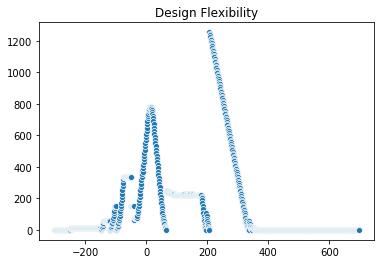

In [68]:
# this quickly computes the minimum cost per span for primers
# todo: handle negative span

import numpy as np

min_anneal = 16.0
day_cost = 20.0
material_importance = 1.0

# material cost
p1 = np.array([0, 0.3, 1.5])
p2 = np.array([0, 0.8, 2.5])

# primer lengths for materials above
a1 = np.arange(min_anneal, 60, dtype=np.int64)
a2 = np.arange(45, 200, dtype=np.int64)
a = np.concatenate([a1, a2])
a = a.reshape((-1, 1))

# # stacked materials cost
p1 = np.broadcast_to(p1, (a1.shape[0], p1.shape[0]))
p2 = np.broadcast_to(p2, (a2.shape[0], p2.shape[0]))
p = np.concatenate([p1, p2])

# materials cost across indices "a", the primer lengths
# materials cost is independent of span
m = p[:, 1, np.newaxis] * a + p[:, 0, np.newaxis]
m = m + m.T
# time cost along indices "a", the primer lengths
# time cost is independent of span
t = p[:, 2, np.newaxis]
t = np.maximum(t, t.T)
print(t.dtype)

# the spanning distance
min_span = -300
max_span = 2*a.max()
span = np.arange(min_span, max_span - min_span, 1)
ext = a - min(a)

# overlap (sum of extensions - span) for primers of lengths a[x], a[y]
relative_span = span - (ext + ext.T)[:, :, np.newaxis] 
print(relative_span.shape)
relative_span = relative_span.swapaxes(2, 0).swapaxes(1, 2)

# sanity checks
assert relative_span[0].shape == (ext.shape[0], ext.shape[0])
assert relative_span[0, 0, 0] == min_span
print(relative_span[:, :, 0])
assert relative_span[0, 1, 0] == min_span - 1
assert relative_span[0, 0, 1] == min_span - 1
assert relative_span[0, 1, 1] == min_span - 2


# print(relative_span)
# o = ((ext + ext.T)[:, :, np.newaxis] + span)
# o = -o.swapaxes(2, 0).swapaxes(1, 2)

# # discontinuous function representing the efficiency for assembly
j = np.zeros(300, dtype=np.float)
j[:10] = 0.0
j[10:20] = 0.1
j[20:30] = 0.8
j[30:40] = 0.9
j[40:50] = 0.8
j[50:100] = 0.75
j[100:120] = 0.5
j[120:150] = 0.3
j[150:250] = 0.1
j[250:300] = 0.0

e = j[np.clip(-relative_span, 0, len(j)-1)]

# # sanity check
# assert e[0].shape == (ext.shape[0], ext.shape[0])

# assert e[0, 0, 0] == 0
# assert e[-min_span, 20, 20] == 0.8
# assert e[-min_span, 20, 0] == 0.8
# assert e[-min_span, 10, 5] == 0.1
# assert e[-min_span, 0, 0] == 0

xyz_costs = (m*material_importance + t*day_cost) * 1./e

print(xyz_costs[:, :, :].shape)


min_cost_per_span = xyz_costs[:, :, :].min(axis=(1,2))


import seaborn as sns
import pylab as plt

fig = plt.figure(figsize=(6,5))
ax = fig.gca()
sns.scatterplot(y= min_cost_per_span, x=min_span + np.arange(len(min_cost_per_span)), ax=ax)
plt.show()

flexibility = []
span = []
for i, x in enumerate(xyz_costs):
    
    span.append(i)
    if x.min() != np.Inf:
        opts = np.argwhere(x < x.min() + 10.)
        flexibility.append(len(opts))
    else:
        flexibility.append(0)
        

sns.scatterplot(x=np.array(span)+min_span, y=flexibility)
plt.title("Design Flexibility")

def junction_cost(x, ext=2):
    if ext == 2:
        min_cost_per_span = xyz_costs[:, :, :].min(axis=(1,2))
    elif ext == 1:
         min_cost_per_span = xyz_costs[:, :1, :].min(axis=(1,2))
    else:
         min_cost_per_span = xyz_costs[:, :1, :1].min(axis=(1,2))
    i = x - min_span
    return min_cost_per_span[np.clip(i, 0, len(min_cost_per_span)-1)]

## Clusting

We will eventually want to resolve design flexibility with cost in a meaningful way.

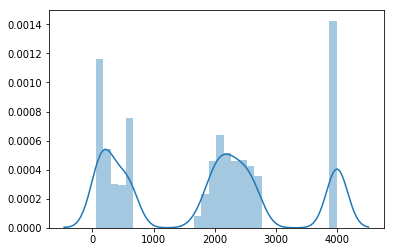

In [5]:
x = xyz_costs[300].copy()
x[x == np.Inf] = 4000
sns.distplot(x.flatten())

## Synthesis and Assembly Cost

We want to interate over:
1. gene size
2. gene shift relative to left end
3. none, one, or both extendable

In [58]:
gene_synthesis_cost = np.zeros((2250, 2))

d = {
            (0, 1): {"base": 0.0, "time": 0},
            (1, 100): {"base": np.Inf, "time": np.Inf},
            (100, 500): {"base": 89.0, "time": 3.0},
            (500, 750): {"base": 129.0, "time": 3.0},
            (750, 1000): {"base": 149.0, "time": 4.0},
            (1000, 1250): {"base": 209.0, "time": 7.0},
            (1250, 1500): {"base": 249.0, "time": 7.0},
            (1500, 1750): {"base": 289.0, "time": 7.0},
            (1750, 2000): {"base": 329.0, "time": 7.0},
            (2000, 2250): {"base": 399.0, "time": 7.0},
        }

# gene_bins =  np.array([0, 1, 100, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250])
# gene_costs = np.array([0, np.Inf , 89.0, 129.0, 149.0, 209.0, 249.0, 289.0, 329.0, 399.0, np.Inf])
# gene_times = np.array([0,  np.Inf, 3.0, 3.0, 4.0, 7.0, 7.0, 7.0, 7.0, 7.0, np.Inf])

for k, v in d.items():
    gene_synthesis_cost[k[0]:k[1]] = np.array([v['base'], v['time']])

gene_sizes = np.arange(len(gene_synthesis_cost)).reshape(-1, 1)
gene_costs = gene_synthesis_cost[:, 0].reshape(-1, 1)
gene_times = gene_synthesis_cost[:, 1].reshape(-1, 1)

gene_costs

array([[  0.],
       [ inf],
       [ inf],
       ...,
       [399.],
       [399.],
       [399.]])

We have four parameters:
1. left cost
2. gene size / gene cost
3. right cost
4. span

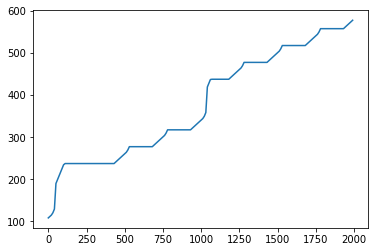

In [244]:
# lets optimize for a single span

def compute_synthesis_costs(left_ext=2, right_ext=2, step_size=5):
    sizes = gene_sizes[::step_size, :]

    span = np.arange(0, 3000, step_size).reshape(1, -1)
    left_span = np.arange(-500, 500, step_size).reshape(-1, 1)[:, np.newaxis]
    left_cost = junction_cost(left_span, ext=left_ext)
    right_span = span - sizes - left_span
    right_cost = junction_cost(right_span, ext=right_ext)
    gene_cost = gene_costs[sizes]
    gene_time = gene_times[sizes]

    # TODO:should just get the material costs here and multiply the efficiencies later
    ext_costs = left_cost + right_cost

    # size, left span, span
    ext_costs = ext_costs.swapaxes(0, 1)
    material = ext_costs + gene_cost
    total = material + gene_time * 20.0
    return total


def optimize_step_size(s, ds):
    step_size = s
    delta_step = ds
    y1 = compute_synthesis_costs(0, 0, step_size).min(axis=(0,1)).flatten()
    x1 = np.arange(len(y1))*step_size
    
    y2 = compute_synthesis_costs(0, 0, step_size-delta_step).min(axis=(0,1)).flatten()
    x2 = np.arange(len(y2))*(step_size-delta_step)
    y2_interp = np.interp(x1, x2, y2)
    diff = ((y1 - y2_interp)**2).sum()/len(y1)
    return diff

# y = []
# x = []
# for i in range(4, 50, 1):
#     y.append(optimize_step_size(i, 1))
#     x.append(i)
# sns.lineplot(x, y)
# plt.show()

def synthesis_cost_dict(step_size):
    d = {'step': step_size}

    d[0] = synthesis_costs(0, 0, step_size).min(axis=(0,1)).flatten()
    d[1] = synthesis_costs(1, 0, step_size).min(axis=(0,1)).flatten()
    d[2] = synthesis_costs(1, 1, step_size).min(axis=(0,1)).flatten()
    
    return d

syn_cost_dict = synthesis_cost_dict(10)

def get_synthesis_cost(span, ext):
    step_size = syn_cost_dict['step']
    return syn_cost_dict[ext][int(span/step_size)]
    

step_size = 10
total = synthesis_costs(2, 0, step_size)
y = total.min(axis=(0,1)).flatten()
sns.lineplot(x=np.arange(len(y))*step_size, y=y)

# total = synthesis_costs(1, 2, step_size)
# y = total.min(axis=(0,1)).flatten()
# sns.lineplot(x=np.arange(len(y))*step_size, y=y)

# total = synthesis_costs(0, 2, step_size)
# y = total.min(axis=(0,1)).flatten()
# sns.lineplot(x=np.arange(len(y))*step_size, y=y)

# total = synthesis_costs(1, 1, step_size)
# y = total.min(axis=(0,1)).flatten()
# sns.lineplot(x=np.arange(len(y))*step_size, y=y)

# total = synthesis_costs(0, 0, step_size)
# y = total.min(axis=(0,1)).flatten()
# sns.lineplot(x=np.arange(len(y))*step_size, y=y)



In [215]:
y.shape

(200,)

In [216]:
z = np.zeros((200, 2, 2))

In [217]:
z[:, 0, 0] = y

In [257]:
recordarr = np.rec.array([(1,2.,'Hello'),(2000000,3000000.0000,"World")],
                  dtype=[('foo', 'i4'),('bar', 'f4'), ('baz', 'S10')])

recordarr.bar

array([2.e+00, 3.e+06], dtype=float32)

In [269]:
        p1 = np.array([0, 0.3, 1.5])
        p2 = np.array([0, 0.8, 2.5])
        
p = np.rec.array([
    [0., 0.3, 1.5],
    [0., 0.8, 2.5]
], dtype=[
    ('base_cost', 'f4'),
    ('bp_cost', 'f4'),
    ('days', 'f4')
])

p

TypeError: data type not understood